# 【开源实习】针对任务类型Video Classification，开发可在香橙派AIpro开发板运行的应用
任务编号：ICJ6R4 任务链接：[【开源实习】针对任务类型Video Classification，开发可在香橙派AIpro开发板运行的应用](https://gitee.com/mindspore/community/issues/ICJ6R4)

## 环境准备
开发者拿到香橙派开发板后，首先需要进行硬件资源确认，镜像烧录及CANN和MindSpore版本的升级，才可运行该案例，具体如下：

开发板：香橙派Aipro或其他同硬件开发板  
开发板镜像: Ubuntu镜像  
CANN Toolkit/Kernels：8.0.0.beta1  
MindSpore: 2.6.0  
MindSpore NLP: 0.4.1  
Python: 3.9

### 镜像烧录
运行该案例需要烧录香橙派官网ubuntu镜像，烧录流程参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--镜像烧录](https://www.mindspore.cn/tutorials/zh-CN/r2.7.0rc1/orange_pi/environment_setup.html) 章节。

### CANN升级
CANN升级参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--CANN升级](https://www.mindspore.cn/tutorials/zh-CN/r2.7.0rc1/orange_pi/environment_setup.html)章节。

### MindSpore升级
MindSpore升级参考[昇思MindSpore官网--香橙派开发专区--环境搭建指南--MindSpore升级](https://www.mindspore.cn/tutorials/zh-CN/r2.7.0rc1/orange_pi/environment_setup.html)章节。

### 权重加载
该应用使用`google/vivit-b-16x2-kinetics400`模型进行实现。
ViViT 全称 Video Vision Transformer，由 Google 提出，是一类纯 Transformer 架构的视频分类模型。

In [1]:
!pip install mindnlp==0.4.1 av opencv-python

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
import os
import av  
import numpy as np
import mindspore as ms
from mindnlp.transformers import VivitImageProcessor, VivitForVideoClassification
import matplotlib.pyplot as plt
import cv2

[WARNING] DEVICE(10955,e7ffd506b020,python):2025-09-04-12:39:01.658.448 [mindspore/ccsrc/utils/dlopen_macro.h:165] DlsymAscend] Dynamically load symbol aclprofGetSupportedFeaturesV2 failed, result = /usr/local/Ascend/ascend-toolkit/latest/lib64/libmsprofiler.so: undefined symbol: aclprofGetSupportedFeaturesV2
[WARNING] DEVICE(10955,e7ffd506b020,python):2025-09-04-12:39:01.658.740 [mindspore/ccsrc/utils/dlopen_macro.h:165] DlsymAscend] Dynamically load symbol aclrtEventGetTimestamp failed, result = /usr/local/Ascend/ascend-toolkit/latest/lib64/libascendcl.so: undefined symbol: aclrtEventGetTimestamp
/usr/local/miniconda3/envs/img/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/miniconda3/envs/img/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'

### 定义帧采样方法和读取视频方法

In [3]:

# 帧采样 & 读取
def sample_frame_indices(clip_len=32, frame_sample_rate=4, seg_len=0):
    """
    从整段视频里均匀采样 clip_len 帧，frame_sample_rate=每隔多少帧取一帧。
    当 seg_len 真实帧数不足时，做边界保护。
    """
    if seg_len == 0:
        return np.arange(0, clip_len)  # 边界
    converted_len = int(np.clip(clip_len * frame_sample_rate, 1, max(seg_len, 1)))
    # 居中裁一段，再在这段里均匀取 clip_len 帧
    start_idx = max(0, (seg_len - converted_len) // 2)
    end_idx = min(seg_len, start_idx + converted_len)
    indices = np.linspace(start_idx, end_idx - 1, num=clip_len, dtype=np.int64)
    return indices

def read_video_pyav(path, indices):
    container = av.open(path)
    stream = container.streams.video[0]
    frames = []
    for i, frame in enumerate(container.decode(stream)):
        if i > indices[-1]:
            break
        if i in set(indices.tolist()):
            img = frame.to_image()              
            frames.append(np.array(img))       
    container.close()
    return np.stack(frames, axis=0)  

### 加载模型

In [ ]:
# 模型与预处理器
# ViViT 使用 32 帧、224 分辨率的预处理
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")
model = VivitForVideoClassification.from_pretrained("google/vivit-b-16x2-kinetics400", ms_dtype=ms.float32)

### 采样视频

In [5]:

# 读取视频 & 采样帧
video_path = "/opt/image2text/shixi/video_cls.mp4"   
assert os.path.exists(video_path), f"File not found: {video_path}"

# 先用 PyAV 打开一次，拿到总帧数
container0 = av.open(video_path)
total_frames = container0.streams.video[0].frames
container0.close()

# 从整段视频均匀采样
indices = sample_frame_indices(clip_len=32, frame_sample_rate=4, seg_len=total_frames)
video_frames = read_video_pyav(video_path, indices)  


### 推理

In [6]:
processed = image_processor(list(video_frames), return_tensors="np")
pixel_values_np = processed["pixel_values"] 
pixel_values = ms.Tensor(pixel_values_np)

model.set_train(False)
outputs = model(pixel_values=pixel_values)  
logits = outputs.logits.asnumpy()
pred_id = int(logits.argmax(-1)[0])



### 将推理结果映射至标签

In [7]:

# cls标签
with open("/opt/image2text/shixi/orange-pi-mindspore/Online/community/07-Video-Classification/cls.txt") as f:
    labels = [line.strip() for line in f]

pred_label = labels[pred_id]

print(f"Pred id: {pred_id}, label: {pred_label}")


Pred id: 213, label: petting cat


### 展示效果

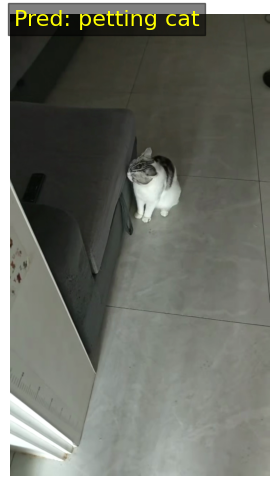

In [8]:
frame = video_frames[0]   
# 在图上显示
plt.figure(figsize=(6,6))
plt.imshow(frame)
plt.axis("off")

# 在左上角加预测类别
plt.text(
    10, 30, 
    f"Pred: {pred_label}", 
    color="yellow", fontsize=16, 
    bbox=dict(facecolor="black", alpha=0.5)
)
plt.show()


### 将采样帧合成视频并保存

In [9]:
save_path = "output_with_pred.mp4"
h, w, _ = video_frames[0].shape
fps = 10  # 输出帧率，可以自己设

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(save_path, fourcc, fps, (w, h))

for frame in video_frames:
    # OpenCV 需要 BGR
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    # 在左上角叠加预测类别
    cv2.putText(
        frame_bgr, f"Pred: {pred_label}", (20, 40),
        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 255), 3
    )
    out.write(frame_bgr)

out.release()
print(f"带预测结果的视频已保存到 {save_path}")


带预测结果的视频已保存到 output_with_pred.mp4
